# Project Bigoni, Meloni, Rossini

# Libraries

In [1]:
# =========================================================
# Core / utilities
# =========================================================
import os
import re
import time
import glob
import sqlite3
import lxml
from datetime import datetime
from io import BytesIO
from zipfile import ZipFile
import xml.etree.ElementTree as ET

# =========================================================
# Data handling
# =========================================================
import pandas as pd
import numpy as np

# =========================================================
# HTTP / API
# =========================================================
import requests
import requests_cache
import openmeteo_requests
from retry_requests import retry

# =========================================================
# HTML parsing (BRef tables in comments)
# =========================================================
from bs4 import BeautifulSoup, Comment

# =========================================================
# Selenium (dynamic scraping)
# =========================================================
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
from io import StringIO


# Set Work directory

In [2]:
#set working directory
os.chdir("/Users/clelia/Desktop/DataManLab/image-lab-pc/work/BikeHistoricalData")
print(os.getcwd())

/Users/clelia/Desktop/DataManLab/image-lab-pc/work/BikeHistoricalData


# 1. Data Acquisition
In this section, we connect to different sources to retrieve the raw data.

## 1.1 Bike Data Acquisition

In [3]:
#look for all citibike data files in the current directory
file_list = glob.glob("*-citibike-tripdata_*.csv")
#exclude files that could be not related to bike data (e.g., Analysis files, knicks files)
file_list = [f for f in file_list if "Analysis" not in f and "knicks" not in f]
print(f"Found {len(file_list)} bike data files.")

Found 53 bike data files.


## 1.2 Weather Data Acquisition
We connect to Open-Meteo API to fetch the raw weather records.

In [4]:
# Set up the API connection with caching
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)
# API URL and parameters (asking for a wide range to cover all potential bike data)
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 40.7128, # New York
    "longitude": -74.0060,
    "start_date": "2024-10-31",
    "end_date": "2025-10-31",
    "hourly": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "weather_code", "wind_speed_10m"],
    "timezone": "America/New_York"
}
# Request the data
weather_responses = openmeteo.weather_api(url, params=params)
raw_weather_response = weather_responses[0]

## 1.3 Knicks Data Acquisition
We use Selenium to scrape the game schedule from ESPN.

In [5]:

def make_driver(headless=False):  #nuova funzione make_driver perchè non ho chrome nel docker
    options = webdriver.ChromeOptions()
    # Le opzioni che avevi già vanno bene
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    # SE IL CODICE È DENTRO DOCKER, DEVI USARE QUESTO:
    # Ci colleghiamo al container "selenium" che vedo nella tua foto sulla porta 4444
    driver = webdriver.Remote(
        command_executor='http://selenium:4444/wd/hub',
        options=options
    )

    return driver

In [ ]:

BASE = "https://www.basketball-reference.com"
TEAM = "NYK"
YEARS = (2025, 2026)


#  Driver setup
def make_driver(headless=False):
    options = webdriver.ChromeOptions()
    if headless:
        options.add_argument("--headless=new")
    options.add_argument("--window-size=1400,900")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    return webdriver.Chrome(options=options)

#  Cookie banner (multilingual))
def accept_cookies_if_present(driver, timeout=6):
    xpaths = [
        "//button[contains(., 'Accetta tutto')]",
        "//button[contains(., 'Accept All')]",
        "//button[contains(., 'Accept all')]",
        "//button[contains(., 'Salva')]",
        "//button[contains(., 'Save')]",
        "//button[contains(., 'Rifiutare')]",
        "//button[contains(., 'Reject')]",
        "//a[contains(., 'Accetta tutto')]",
        "//a[contains(., 'Accept All')]",
                ]
    for xp in xpaths:
        try:
            btn = WebDriverWait(driver, timeout).until(
                EC.element_to_be_clickable((By.XPATH, xp))
            )
            btn.click()
            time.sleep(0.4)
            return True
        except Exception:
            pass
    return False


#  Extract RAW games table (no cleaning)

def extract_games_df_raw(page_html: str) -> pd.DataFrame:
    tables = pd.read_html(StringIO(page_html), attrs={"id": "games"})
    if not tables:
        raise ValueError("table id='games' not found.")
    return tables[0].copy()

# Main scraper (dynamic via Selenium, no click)

def scrape_knicks_games_raw(years=(2025, 2026), headless=False) -> pd.DataFrame:
    driver = make_driver(headless=headless)
    wait = WebDriverWait(driver, 20)

    frames = []
    try:
        for year in years:
            url = f"{BASE}/teams/{TEAM}/{year}_games.html"
            driver.get(url)

            # dynamic sync: page loaded
            wait.until(EC.presence_of_element_located((By.TAG_NAME, "body")))
            accept_cookies_if_present(driver)

            time.sleep(0.8)

            df_raw = extract_games_df_raw(driver.page_source)

            # minimal metadata only (not domain cleaning)
            df_raw.insert(0, "season_year", year)
            frames.append(df_raw)

        return pd.concat(frames, ignore_index=True)

    finally:
        driver.quit()


# RUN + save (RAW only)

if __name__ == "__main__":
    df_raw_all = scrape_knicks_games_raw(YEARS, headless=False)
    df_raw_all.to_csv("knicks_bref_RAW_dynamic.csv", index=False)

# 2. Pre-processing and Cleaning
Now we take the raw data and clean it up for analysis

## 2.1 Bike Data Cleaning
We iterate through files, filter bad trips, and aggregate by hour.

In [ ]:
all_hourly_data = []

# Loop su ogni file
for file in file_list:
        df = pd.read_csv(file, usecols=['started_at', 'ended_at', 'member_casual'])

        # convert all time columns to datetime
        df['started_at'] = pd.to_datetime(df['started_at'])
        df['ended_at'] = pd.to_datetime(df['ended_at'])

        #   claculate all trip duration in minutes
        df['duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

        # only trips between 1 minute and 3 hours
        df = df[(df['duration_min'] > 1) & (df['duration_min'] < 180)].copy() # perche cazzo lo facciamo

        # count members and casual
        df['member_count'] = np.where(df['member_casual'].str.contains('member|Subscriber', case=False, na=False), 1, 0)
        df['casual_count'] = np.where(df['member_casual'].str.contains('casual|Customer', case=False, na=False), 1, 0)

        # creation of an date and hour column
        df['date']=df['started_at'].dt.date
        df['time_hour']=df['started_at'].dt.floor('h')
        df['time_hour']=df['time_hour'].dt.strftime('%H:%M')

        # Aggregartio per hour (summs)
        hourly_stats = df.groupby(['date', 'time_hour']).agg(
            total_trips=('started_at', 'count'),
            sum_duration_min=('duration_min', 'sum'),
            member_count=('member_count', 'sum'),
            casual_count=('casual_count', 'sum')
        ).reset_index()


        all_hourly_data.append(hourly_stats)

    #except Exception as e:
    #    print("Could not read file:", file)
    #    print("Reason:", e)

df_bike = (pd.concat(all_hourly_data).groupby(['date', 'time_hour'], as_index=False).sum())

# calculate final average duration
df_bike['avg_duration_min'] = df_bike['sum_duration_min'] / df_bike['total_trips']

df_bike = df_bike.sort_values(['date', 'time_hour'])
df_bike['avg_duration_min'] = df_bike['avg_duration_min'].round(2)
df_bike['sum_duration_min'] = df_bike['sum_duration_min'].round(2)

print("Bike data ready! Rows:", len(df_bike))
print("Max average duration:", df_bike['avg_duration_min'].max())

Bike data ready! Rows: 8762
Max average duration: 156.89


In [ ]:
df_bike.to_csv('checkpoitn_bici_8_01.csv')

In [ ]:
df_bike

,date,time_hour,total_trips,sum_duration_min,member_count,casual_count,avg_duration_min
0,2024-10-31,21:00,2,313.79,1,1,156.89
1,2024-10-31,22:00,20,2133.32,5,15,106.67
2,2024-10-31,23:00,981,22281.93,677,304,22.71
3,2024-11-01,00:00,4023,53396.29,2888,1135,13.27
4,2024-11-01,01:00,2667,35169.29,1845,822,13.19
...,...,...,...,...,...,...,...
8757,2025-10-31,19:00,8910,105210.18,7239,1671,11.81
8758,2025-10-31,20:00,7099,85519.13,5601,1498,12.05
8759,2025-10-31,21:00,5735,70232.43,4401,1334,12.25
8760,2025-10-31,22:00,5002,61096.57,3752,1250,12.21


## 2.2 Weather Data Cleaning
We process the API response into a clean DataFrame and handle timezones.

In [ ]:
hourly = raw_weather_response.Hourly()
hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
)}

hourly_data["temp_c"] = np.round(hourly.Variables(0).ValuesAsNumpy(), 1)  #temperature
hourly_data["humidity"] = np.round(hourly.Variables(1).ValuesAsNumpy(), 1) #humidity
hourly_data["temp_apparent_c"] = np.round(hourly.Variables(2).ValuesAsNumpy(), 1)  #temperature_apparent
hourly_data["rain_mm"] = np.round(hourly.Variables(3).ValuesAsNumpy(), 1) #rain
hourly_data["weather_code"] = hourly.Variables(4).ValuesAsNumpy()   #type_weather
hourly_data["wind_kmh"] = np.round(hourly.Variables(5).ValuesAsNumpy(), 1) #wind

df_weather = pd.DataFrame(data = hourly_data)
df_weather['date'] = df_weather['date'].dt.tz_localize(None) # Remove time zone info to match bike data

In [ ]:

#df_weather.columns = df_weather.columns.str.strip()
# convertion and rounding (fix fort the infinite decimals)
cols_to_fix = ['temp_c', 'humidity', 'temp_apparent_c', 'rain_mm', 'wind_kmh']
df_weather[cols_to_fix] = df_weather[cols_to_fix].astype(float).round(1)

# convert the date and create the primary key (pk_dt)
df_weather['date'] = pd.to_datetime(df_weather['date'])

print(len(df_weather))
df_weather.head()

8760


,date,temp_c,humidity,temp_apparent_c,rain_mm,weather_code,wind_kmh,pk_dt
0,2024-11-01 00:00:00,23.0,53.5,21.2,0.0,3.0,18.6,2024110100
1,2024-11-01 01:00:00,22.4,56.4,20.4,0.0,3.0,20.8,2024110101
2,2024-11-01 02:00:00,21.9,59.3,20.0,0.0,3.0,21.2,2024110102
3,2024-11-01 03:00:00,21.7,61.4,19.7,0.0,3.0,22.2,2024110103
4,2024-11-01 04:00:00,21.4,63.1,19.2,0.0,3.0,24.6,2024110104


## 2.3 Knicks Data Cleaning
We ensure dates are correct and categorize games as Home or Away.

In [ ]:

def add_date_time_home_away_from_bref(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # repeted headers inside BRef table -> keeps only matchin Rk numeric rows
    if "Rk" in out.columns:
        out = out[out["Rk"].astype(str).str.match(r"^\d+$", na=False)].copy()

    # 1) HOME / AWAY -> inside the dataset the 'away' maker is in "Unnamed: 5" with value "@"

    away_marker = out["Unnamed: 5"].astype(str).str.strip()
    out["home_away"] = np.where(away_marker.eq("@"), "away", "home")

    #  date -> AAAA/MM/GG

    out["date_dt"] = pd.to_datetime(out["Date"], errors="coerce")
    out["date_yyyy_mm_dd"] = out["date_dt"].dt.strftime("%Y/%m/%d")


    # 3) hours -> 24h (HH:MM)
    # Start (ET) esempio: "7:30p", "7:00p"
    start_raw = out["Start (ET)"].astype(str).str.strip()

    # converting "7:30p" -> "7:30 PM", "11:00a" -> "11:00 AM"
    start_norm = (
        start_raw
        .str.replace(r"(?i)\s*tbd\s*", "", regex=True)
        .str.replace(r"(?i)a$", " AM", regex=True)
        .str.replace(r"(?i)p$", " PM", regex=True)
        .str.strip()
    )

    t = pd.to_datetime(start_norm, format="%I:%M %p", errors="coerce")
    out["time_24h"] = t.dt.strftime("%H:%M")

    return out


df2 = add_date_time_home_away_from_bref(df_raw_all)

In [ ]:

df_knicks = df2.loc[:, [
    "date_yyyy_mm_dd", "time_24h", "home_away", "Opponent",
    "Tm", "Opp", "W", "L", "Streak", "LOG"
]].copy()

# remove repeated headers inside BRef table (data cleaning)
mask_header = (
    df_knicks["Opponent"].astype(str).str.strip().eq("Opponent") |
    df_knicks["W"].astype(str).str.strip().eq("W")
)
df_knicks = df_knicks.loc[~mask_header].copy()

# Parse datetime base
dt = pd.to_datetime(
    df_knicks["date_yyyy_mm_dd"].astype(str) + " " + df_knicks["time_24h"].astype(str),
    format="%Y/%m/%d %H:%M",
    errors="coerce"
)

# dropping eventual rows that could not be parsed
df_knicks = df_knicks.loc[dt.notna()].copy()
dt = dt.loc[dt.notna()]

# rounding to the nearest hour (:00–:30 previous, :31–:59 next) -> to allineate with wether and bike data
dt_rounded = dt.dt.floor("h").where(dt.dt.minute <= 30, dt.dt.ceil("h"))

df_knicks["time_24h"] = dt_rounded.dt.strftime("%H:00")

print(df_knicks.head())

  date_yyyy_mm_dd time_24h home_away             Opponent   Tm  Opp  W  L  \
0      2024/10/22    19:00      away       Boston Celtics  109  132  0  1   
1      2024/10/25    19:00      home       Indiana Pacers  123   98  1  1   
2      2024/10/28    19:00      home  Cleveland Cavaliers  104  110  1  2   
3      2024/10/30    19:00      away           Miami Heat  116  107  2  2   
4      2024/11/01    19:00      away      Detroit Pistons  128   98  3  2   

  Streak   LOG  
0    L 1  2:04  
1    W 1  2:21  
2    L 1  2:23  
3    W 1  2:10  
4    W 2  1:55  


In [ ]:
df_knicks

,date_yyyy_mm_dd,time_24h,home_away,Opponent,Tm,Opp,W,L,Streak,LOG
0,2024/10/22,19:00,away,Boston Celtics,109,132,0,1,L 1,2:04
1,2024/10/25,19:00,home,Indiana Pacers,123,98,1,1,W 1,2:21
2,2024/10/28,19:00,home,Cleveland Cavaliers,104,110,1,2,L 1,2:23
3,2024/10/30,19:00,away,Miami Heat,116,107,2,2,W 1,2:10
4,2024/11/01,19:00,away,Detroit Pistons,128,98,3,2,W 2,1:55
...,...,...,...,...,...,...,...,...,...,...
166,2026/04/03,19:00,home,Chicago Bulls,NaN,NaN,NaN,NaN,NaN,NaN
167,2026/04/06,19:00,away,Atlanta Hawks,NaN,NaN,NaN,NaN,NaN,NaN
168,2026/04/09,19:00,home,Boston Celtics,NaN,NaN,NaN,NaN,NaN,NaN
170,2026/04/10,19:00,home,Toronto Raptors,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Data Integration

## 3.1 Primary Key Generation & Alignment

### 3.1.1 Bike data


In [ ]:
# union of date and time_hour into a single datetime column
dt_temp = pd.to_datetime(df_bike['date'].astype(str) + ' ' + df_bike['time_hour'].astype(str))

# rounding, if minutes <=30 round down, else round up
dt_rounded = dt_temp.dt.floor("h").where(dt_temp.dt.minute <= 30, dt_temp.dt.ceil("h"))

# genering. a primary key (pk_dt) in YYYYMMDDHH format
df_bike['pk_dt'] = dt_rounded.dt.strftime("%Y%m%d%H").astype("int64")

# defining the time range to filter basing on the key (YYYYMMDDHH): start Nov 1 at 00;00, 2024 to Oct 31 at 23:00, 2025
pk_start = 2024110100
pk_end = 2025103123

df_bike = df_bike.loc[(df_bike['pk_dt'] >= pk_start) & (df_bike['pk_dt'] <= pk_end)].reset_index(drop=True)

# Controllo veloce
print(df_bike['pk_dt'].min())
print(df_bike['pk_dt'].max())


2024110100
2025103123


In [ ]:
df_bike

,date,time_hour,total_trips,sum_duration_min,member_count,casual_count,avg_duration_min,pk_dt
0,2024-11-01,00:00,4023,53396.29,2888,1135,13.27,2024110100
1,2024-11-01,01:00,2667,35169.29,1845,822,13.19,2024110101
2,2024-11-01,02:00,1690,22771.54,1141,549,13.47,2024110102
3,2024-11-01,03:00,1073,14562.98,755,318,13.57,2024110103
4,2024-11-01,04:00,857,10331.25,616,241,12.06,2024110104
...,...,...,...,...,...,...,...,...
8754,2025-10-31,19:00,8910,105210.18,7239,1671,11.81,2025103119
8755,2025-10-31,20:00,7099,85519.13,5601,1498,12.05,2025103120
8756,2025-10-31,21:00,5735,70232.43,4401,1334,12.25,2025103121
8757,2025-10-31,22:00,5002,61096.57,3752,1250,12.21,2025103122


### 3.1.2 Weather data

In [ ]:
df_weather['pk_dt'] = df_weather['date'].dt.floor('h').dt.strftime("%Y%m%d%H").astype("int64")

#filetr for the analysis period (01/11/2024 00:00 - 31/10/2025 23:00)
pk_start = 2024110100
pk_end = 2025103123

df_weather = df_weather.loc[(df_weather['pk_dt'] >= pk_start) & (df_weather['pk_dt'] <= pk_end)].reset_index(drop=True)


In [ ]:
df_weather

,date,temp_c,humidity,temp_apparent_c,rain_mm,weather_code,wind_kmh,pk_dt
0,2024-11-01 00:00:00,23.0,53.5,21.2,0.0,3.0,18.6,2024110100
1,2024-11-01 01:00:00,22.4,56.4,20.4,0.0,3.0,20.8,2024110101
2,2024-11-01 02:00:00,21.9,59.3,20.0,0.0,3.0,21.2,2024110102
3,2024-11-01 03:00:00,21.7,61.4,19.7,0.0,3.0,22.2,2024110103
4,2024-11-01 04:00:00,21.4,63.1,19.2,0.0,3.0,24.6,2024110104
...,...,...,...,...,...,...,...,...
8755,2025-10-31 19:00:00,13.6,47.0,8.1,0.0,3.0,25.7,2025103119
8756,2025-10-31 20:00:00,13.1,52.0,7.6,0.0,1.0,27.4,2025103120
8757,2025-10-31 21:00:00,12.4,52.3,6.9,0.0,1.0,26.3,2025103121
8758,2025-10-31 22:00:00,11.7,54.0,7.0,0.0,1.0,20.6,2025103122


### 3.1.3 Knicks games data

In [ ]:
# primary key (pk_dt) in YYYYMMDDHH format
df_knicks["pk_dt"] = dt_rounded.dt.strftime("%Y%m%d%H").astype("int64")

# filter period of interest
start = pd.Timestamp("2024-11-01")
end   = pd.Timestamp("2025-10-31 23:59:59")

mask_period = (dt_rounded >= start) & (dt_rounded <= end)
df_knicks = df_knicks.loc[mask_period].reset_index(drop=True)


In [ ]:
df_knicks

,date_yyyy_mm_dd,time_24h,home_away,Opponent,Tm,Opp,W,L,Streak,LOG,pk_dt
0,2024/10/22,19:00,away,Boston Celtics,109,132,0,1,L 1,2:04,2024110100
1,2024/10/25,19:00,home,Indiana Pacers,123,98,1,1,W 1,2:21,2024110101
2,2024/10/28,19:00,home,Cleveland Cavaliers,104,110,1,2,L 1,2:23,2024110102
3,2024/10/30,19:00,away,Miami Heat,116,107,2,2,W 1,2:10,2024110103
4,2024/11/01,19:00,away,Detroit Pistons,128,98,3,2,W 2,1:55,2024110104
...,...,...,...,...,...,...,...,...,...,...,...
159,2026/04/03,19:00,home,Chicago Bulls,NaN,NaN,NaN,NaN,NaN,NaN,2024110722
160,2026/04/06,19:00,away,Atlanta Hawks,NaN,NaN,NaN,NaN,NaN,NaN,2024110723
161,2026/04/09,19:00,home,Boston Celtics,NaN,NaN,NaN,NaN,NaN,NaN,2024110800
162,2026/04/10,19:00,home,Toronto Raptors,NaN,NaN,NaN,NaN,NaN,NaN,2024110802


## 3.2 Investigation of Correspondences (Consistency Check)
We check if the datasets cover the same time periods to ensure a good merge.

In [ ]:
print(f"Bike Key Range:    {df_bike['pk_dt'].min()} to {df_bike['pk_dt'].max()}")
print(f"Weather Key Range: {df_weather['pk_dt'].min()} to {df_weather['pk_dt'].max()}")
print(f"Knicks Key Range:  {df_knicks['pk_dt'].min()} to {df_knicks['pk_dt'].max()}")
# Check Weather Coverage
missing_keys = df_bike[~df_bike['pk_dt'].isin(df_weather['pk_dt'])]
if not missing_keys.empty:
    print( len(missing_keys))
else:
    print("total coverage")

Bike Key Range:    2024110100 to 2025103123
Weather Key Range: 2024110100 to 2025103123
Knicks Key Range:  2024110100 to 2024110803
total coverage


## 3.3 Data Consolidation Strategy

### 3.3.1 Data Enrichment: Temporal Window Expansion (Knicks)

In [ ]:
df_knicks.columns

Index(['date_yyyy_mm_dd', 'time_24h', 'home_away', 'Opponent', 'Tm', 'Opp',
       'W', 'L', 'Streak', 'LOG', 'pk_dt'],
      dtype='object')

In [ ]:
# advanced feature engineering
# expansion temporal window for knicks events
knicks_expanded_list = []

for _, row in df_knicks.iterrows():
    game_pk = row['pk_dt']
    base_time = pd.to_datetime(str(game_pk), format='%Y%m%d%H')

    # Window: 1 hour before, during, 1 hour after, 2 hours after
    offsets = [-1, 0, 1, 2]
    for h in offsets:
        new_time = base_time + pd.Timedelta(hours=h)
        new_pk = int(new_time.strftime('%Y%m%d%H'))
        knicks_expanded_list.append({
            'pk_dt': new_pk,
            'is_knicks_event': 1,
            'opponent': row['Opponent'],
            'home_away': row['home_away'],
            'Tm': row['Tm'],
            'W': row['W'],
            'L': row['L'],
            'Streak': row['Streak'],
            'LOG': row['LOG']
        })

df_knicks_EXTENDED= pd.DataFrame(knicks_expanded_list)
# Rimuoviamo duplicati (se due finestre si sovrappongono) -> per un aumento dati futuro viene inserito nel cosice ma effettivamente non
# è  necessario dal momento che il caso preso in analisi è molto specifico (knicks)
#df_knicks_EXTENDED = df_knicks_EXTENDED.drop_duplicates(subset=['pk_dt'])


In [ ]:
df_knicks_EXTENDED

,pk_dt,is_knicks_event,opponent,home_away,Tm,W,L,Streak,LOG
0,2024103123,1,Boston Celtics,away,109,0,1,L 1,2:04
1,2024110100,1,Boston Celtics,away,109,0,1,L 1,2:04
2,2024110101,1,Boston Celtics,away,109,0,1,L 1,2:04
3,2024110102,1,Boston Celtics,away,109,0,1,L 1,2:04
4,2024110100,1,Indiana Pacers,home,123,1,1,W 1,2:21
...,...,...,...,...,...,...,...,...,...
651,2024110804,1,Toronto Raptors,home,NaN,NaN,NaN,NaN,NaN
652,2024110802,1,Charlotte Hornets,home,NaN,NaN,NaN,NaN,NaN
653,2024110803,1,Charlotte Hornets,home,NaN,NaN,NaN,NaN,NaN
654,2024110804,1,Charlotte Hornets,home,NaN,NaN,NaN,NaN,NaN


### 3.3.2 Execution of Merges (Bike + Weather + Events)

In [ ]:
#final data integration
# bike + mwether
df_integrated = pd.merge(df_bike, df_weather,
                         on='pk_dt', how='left')

# merge Knicks (temporal window)
df_integrated = pd.merge(df_integrated, df_knicks_EXTENDED, on='pk_dt', how='left')

# manage of null cases -> no knicks event
df_integrated['is_knicks_event'] = df_integrated['is_knicks_event'].fillna(0).astype(int)
df_integrated['opponent'] = df_integrated['opponent'].fillna("No Game")


In [ ]:
df_integrated.columns

Index(['date_x', 'time_hour', 'total_trips', 'sum_duration_min',
       'member_count', 'casual_count', 'avg_duration_min', 'pk_dt', 'date_y',
       'temp_c', 'humidity', 'temp_apparent_c', 'rain_mm', 'weather_code',
       'wind_kmh', 'is_knicks_event', 'opponent', 'home_away', 'Tm', 'W', 'L',
       'Streak', 'LOG'],
      dtype='object')

## 3.4 Target Variable Construction (Demand Class Definition)

In [ ]:
# create target class based on quantiles
q1 = df_integrated['total_trips'].quantile(0.25)
q3 = df_integrated['total_trips'].quantile(0.75)

def classify(trips):
    if trips < q1: return 0 # Low
    elif trips > q3: return 2 # High
    else: return 1 # Medium

df_integrated['demand_class'] = df_integrated['total_trips'].apply(classify)


In [ ]:
df_integrated

,date_x,time_hour,total_trips,sum_duration_min,member_count,casual_count,avg_duration_min,pk_dt,date_y,temp_c,...,wind_kmh,is_knicks_event,opponent,home_away,Tm,W,L,Streak,LOG,demand_class
0,2024-11-01,00:00,4023,53396.29,2888,1135,13.27,2024110100,2024-11-01 00:00:00,23.0,...,18.6,1,Boston Celtics,away,109,0,1,L 1,2:04,1
1,2024-11-01,00:00,4023,53396.29,2888,1135,13.27,2024110100,2024-11-01 00:00:00,23.0,...,18.6,1,Indiana Pacers,home,123,1,1,W 1,2:21,1
2,2024-11-01,01:00,2667,35169.29,1845,822,13.19,2024110101,2024-11-01 01:00:00,22.4,...,20.8,1,Boston Celtics,away,109,0,1,L 1,2:04,1
3,2024-11-01,01:00,2667,35169.29,1845,822,13.19,2024110101,2024-11-01 01:00:00,22.4,...,20.8,1,Indiana Pacers,home,123,1,1,W 1,2:21,1
4,2024-11-01,01:00,2667,35169.29,1845,822,13.19,2024110101,2024-11-01 01:00:00,22.4,...,20.8,1,Cleveland Cavaliers,home,104,1,2,L 1,2:23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9235,2025-10-31,19:00,8910,105210.18,7239,1671,11.81,2025103119,2025-10-31 19:00:00,13.6,...,25.7,0,No Game,NaN,NaN,NaN,NaN,NaN,NaN,2
9236,2025-10-31,20:00,7099,85519.13,5601,1498,12.05,2025103120,2025-10-31 20:00:00,13.1,...,27.4,0,No Game,NaN,NaN,NaN,NaN,NaN,NaN,1
9237,2025-10-31,21:00,5735,70232.43,4401,1334,12.25,2025103121,2025-10-31 21:00:00,12.4,...,26.3,0,No Game,NaN,NaN,NaN,NaN,NaN,NaN,1
9238,2025-10-31,22:00,5002,61096.57,3752,1250,12.21,2025103122,2025-10-31 22:00:00,11.7,...,20.6,0,No Game,NaN,NaN,NaN,NaN,NaN,NaN,1


# 4. Storage
We execute the merges and save the final result.

In [ ]:
def save_incremental_to_sqlite(df_new, db_name='nyc_mobility.db'):
    conn = sqlite3.connect(db_name)
    try:
        df_old = pd.read_sql("SELECT * FROM abt_classification", conn)
    except:
        df_old = pd.DataFrame()

    # union and deduplication
    df_combined = pd.concat([df_old, df_new])
    df_final_storage = df_combined.drop_duplicates(subset=['pk_dt'], keep='last')

    df_final_storage.to_sql('abt_classification', conn, if_exists='replace', index=False)
    conn.close()
    print(len(df_final_storage))

save_incremental_to_sqlite(df_integrated)

Salvataggio DB Completato. Righe totali: 8759


/var/folders/f_/z2nqxw151bq75rxk7ygykwz40000gn/T/ipykernel_33805/943365195.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_old, df_new])


In [ ]:
# SQLlite analysis queries

# Connect to the newdatabase
conn = sqlite3.connect('nyc_mobility.db')


# QUERY 1: Validation of the signal feature (is_knicks_event)
#  showing that if there's a Knicks game, trips increase.
# QUERY 3: Impact analysis of home vs away games
query_signal_home = """
SELECT
    CASE
        WHEN is_knicks_event = 0 THEN 'No game'
        WHEN is_knicks_event = 1 AND home_away = 'home' THEN 'home game'
        WHEN is_knicks_event = 1 AND home_away = 'away' THEN 'away game'
        ELSE 'Altro'
    END as event_type,
    COUNT(*) as total_hours,
    ROUND(AVG(total_trips), 0) as avarage_hourly_trips
FROM abt_classification
GROUP BY event_type
ORDER BY avarage_hourly_trips DESC;
"""

df_q1 = pd.read_sql(query_signal_home, conn)
print("query1:\n",df_q1.to_string(index=False))


# QUERY 2: chack meteorological impact on demand
# how much did the request vary based on weather conditions and demand class
query_weather = """
SELECT
CASE
    WHEN rain_mm = 0 THEN 'Clear'
    WHEN rain_mm > 0 AND rain_mm < 2 THEN 'Light Rain'
    WHEN rain_mm >= 2 AND rain_mm < 7 THEN 'Moderate Rain'
    WHEN rain_mm >= 7 THEN 'Heavy Rain'
END as weather_condition,
    ROUND(AVG(total_trips), 0) as avarage_trips
FROM abt_classification
GROUP BY weather_condition
ORDER BY avarage_trips DESC;
"""
df_q2 = pd.read_sql(query_weather, conn)
print("\n --------------------- \n","query2:\n",df_q2.to_string(index=False))


query1:
 event_type  total_hours  avarage_hourly_trips
 away game           87                6502.0
 home game           87                6367.0
   No game         8585                5254.0

 --------------------- 
 query2:
 weather_condition  avarage_trips
            Clear         5445.0
       Light Rain         4350.0
       Heavy Rain         4239.0
    Moderate Rain         3667.0


BASIC STATISTICS
        total_trips  sum_duration_min  member_count  casual_count  \
count   9240.000000       9240.000000   9240.000000   9240.000000   
mean    5340.701190      64802.102867   4398.516883    942.184307   
min       52.000000        394.190000     48.000000      2.000000   
25%     1481.000000      15161.145000   1210.000000    225.000000   
50%     4548.000000      48014.525000   3855.000000    617.000000   
75%     8110.000000      96925.282500   6657.750000   1369.000000   
max    20563.000000     364431.400000  17723.000000   6861.000000   
std     4307.876247      58765.313187   3530.601910    930.424243   

       avg_duration_min         pk_dt                         date_y  \
count       9240.000000  9.240000e+03                           9240   
mean          11.333924  2.024859e+09  2025-04-23 04:06:23.376623360   
min            6.690000  2.024110e+09            2024-11-01 00:00:00   
25%            9.780000  2.025012e+09            2025-01-16 04:45:00   
5

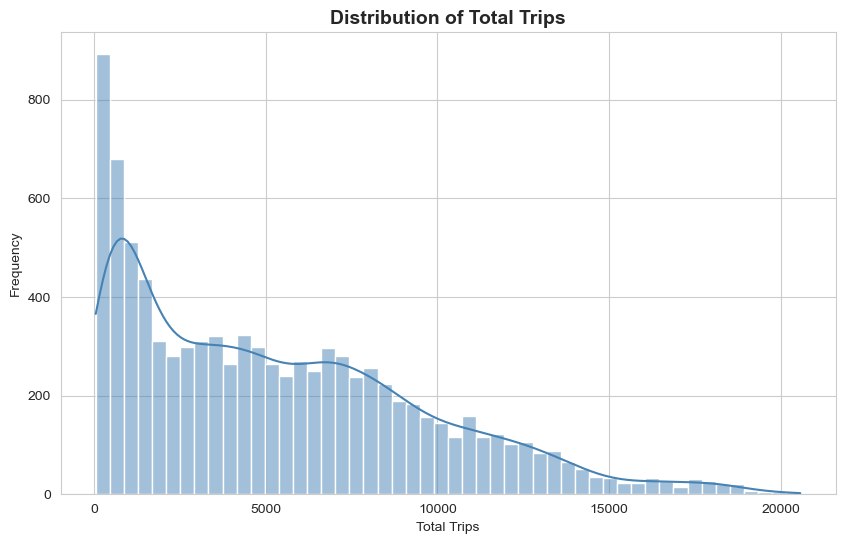

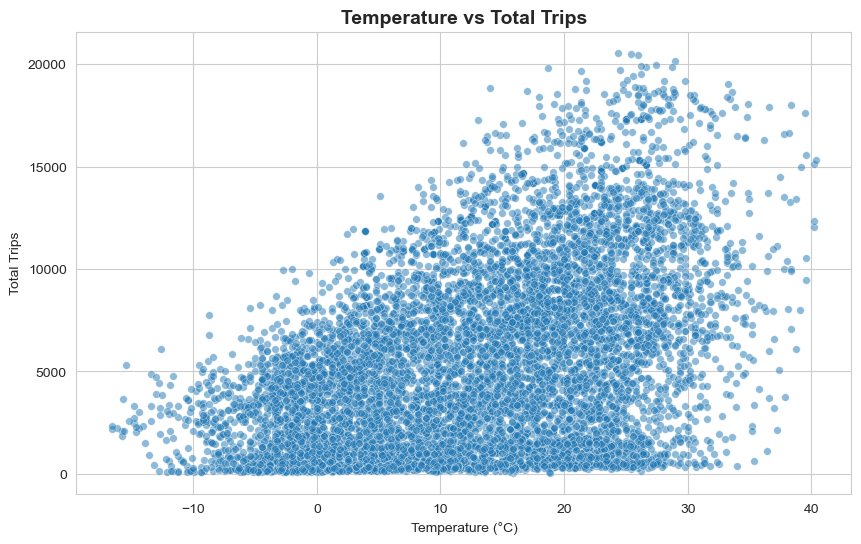

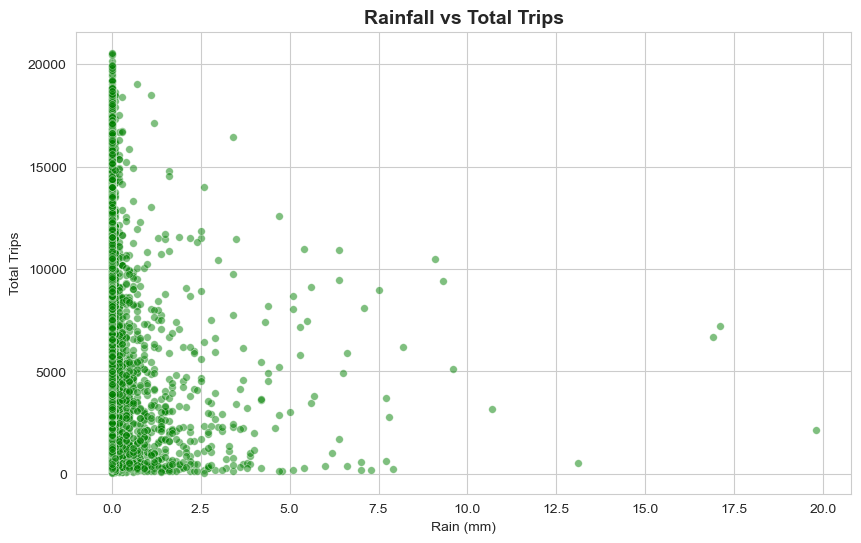

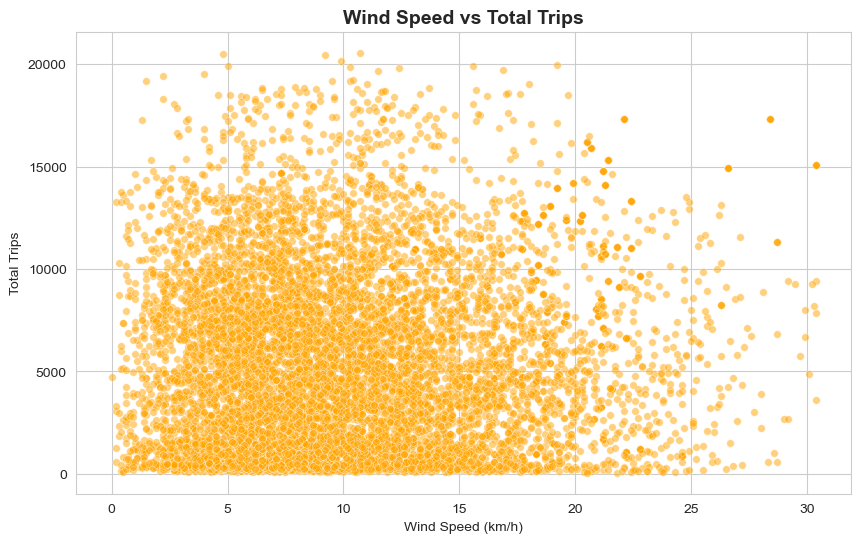

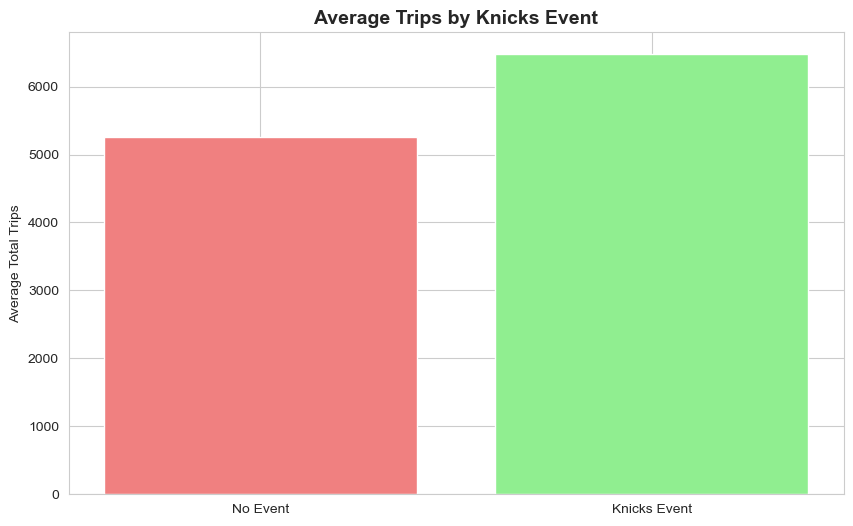

/var/folders/f_/z2nqxw151bq75rxk7ygykwz40000gn/T/ipykernel_33805/3804313326.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='demand_class', y='total_trips', data=df_integrated, palette="viridis")


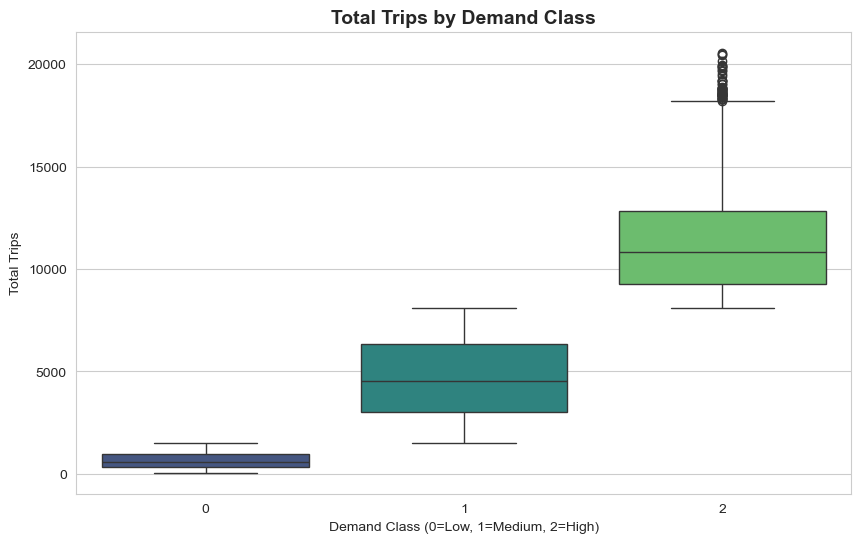

CORRELATION WITH TOTAL TRIPS
total_trips        1.000000
demand_class       0.880513
temp_c             0.415349
is_knicks_event    0.072767
wind_kmh           0.046280
rain_mm           -0.063884
humidity          -0.249935
Name: total_trips, dtype: float64
MEMBER vs CASUAL TRIPS
Total Member Trips: 40,642,296 (82.4%)
Total Casual Trips: 8,705,783 (17.6%)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exploratory Data Analysis (EDA) of df_integrated
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


# 1. Basic statistics
print("BASIC STATISTICS")
print(df_integrated.describe())
print("\nData shape:", df_integrated.shape)
print("Missing values:\n", df_integrated.isnull().sum())

# 2. Demand class distribution
print("DEMAND CLASS DISTRIBUTION")
demand_counts = df_integrated['demand_class'].value_counts().sort_index()
print(demand_counts)
print("\nPercentage distribution:")
print((demand_counts / len(df_integrated) * 100).round(2))

# Total trips distribution
plt.figure()
sns.histplot(df_integrated['total_trips'], bins=50, kde=True, color='steelblue')
plt.title('Distribution of Total Trips', fontsize=14, fontweight='bold')
plt.xlabel('Total Trips')
plt.ylabel('Frequency')
plt.show() # Questo comando forza la visualizzazione e chiude la figura corrente

# Temperature vs trips
plt.figure()
sns.scatterplot(x=df_integrated['temp_c'], y=df_integrated['total_trips'], alpha=0.5, s=30)
plt.title('Temperature vs Total Trips', fontsize=14, fontweight='bold')
plt.xlabel('Temperature (°C)')
plt.ylabel('Total Trips')
plt.show()

# Rain vs trips
plt.figure()
sns.scatterplot(x=df_integrated['rain_mm'], y=df_integrated['total_trips'], alpha=0.5, s=30, color='green')
plt.title('Rainfall vs Total Trips', fontsize=14, fontweight='bold')
plt.xlabel('Rain (mm)')
plt.ylabel('Total Trips')
plt.show()

# Wind vs trips
plt.figure()
sns.scatterplot(x=df_integrated['wind_kmh'], y=df_integrated['total_trips'], alpha=0.5, s=30, color='orange')
plt.title('Wind Speed vs Total Trips', fontsize=14, fontweight='bold')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Total Trips')
plt.show()

# Knicks event impact
knicks_trips = df_integrated.groupby('is_knicks_event')['total_trips'].mean()
plt.figure()
plt.bar(['No Event', 'Knicks Event'], knicks_trips.values, color=['lightcoral', 'lightgreen'])
plt.title('Average Trips by Knicks Event', fontsize=14, fontweight='bold')
plt.ylabel('Average Total Trips')
plt.show()

# Demand class box plot
sns.boxplot(x='demand_class', y='total_trips', data=df_integrated, palette="viridis")
plt.title('Total Trips by Demand Class', fontsize=14, fontweight='bold')
plt.xlabel('Demand Class (0=Low, 1=Medium, 2=High)')
plt.ylabel('Total Trips')
plt.show()


# 4. Correlation analysis
print("CORRELATION WITH TOTAL TRIPS")
numeric_cols = ['total_trips', 'temp_c', 'humidity', 'rain_mm', 'wind_kmh', 'is_knicks_event', 'demand_class']

corr = df_integrated[numeric_cols].corr()['total_trips'].sort_values(ascending=False)
print(corr)

# 5. Member vs Casual distribution
print("MEMBER vs CASUAL TRIPS")
total_members = df_integrated['member_count'].sum()
total_casual = df_integrated['casual_count'].sum()
print(f"Total Member Trips: {total_members:,} ({total_members/(total_members+total_casual)*100:.1f}%)")
print(f"Total Casual Trips: {total_casual:,} ({total_casual/(total_members+total_casual)*100:.1f}%)")